In [ ]:
! pip install --quiet environs cyksuid toolz psycopg2-binary typing_json statsmodels
! pip install --quiet backoff xxhash pyyaml geopandas dtreeviz facebook_business pystache
! pip install --quiet bambi
! pip install git+https://github.com/nandanrao/typedjson-python

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
from environs import Env
from adopt.malaria import get_db_conf

env = Env()
env.read_env('.env-bug', override=True)

db_conf = get_db_conf(env)

In [17]:
import geopandas as gpd
import pandas as pd
from scipy.special import expit


def get_dist_info(path):
    geod = gpd.read_file(path)
    district_info = geod.groupby('disthash').apply(lambda df: df.iloc[0][['disthash', 'tot_p']]).reset_index(drop=True)
    return district_info

dist_stats = get_dist_info('outs/cluster.shp')
treatment_assignment = pd.read_csv('outs/ma-with-treatment.csv')[['disthash', 'treatment']]
dist_info = pd.read_csv('outs/dist_info.csv')

In [672]:
from mnm.prep import *

In [674]:
forms, form_keys = get_form_data(['malaria no more'], db_conf)

In [ ]:
[f['shortcode'] for f in forms]

In [852]:
from mnm.prep import get_response_df_round_a

dda = get_response_df_round_a(['malaria no more'], 'http://localhost:1323', db_conf)
dda = dda \
    .merge(treatment_assignment, how='right', left_on='clusterid', right_on='disthash') \
    .merge(dist_info, on='clusterid')

In [ ]:
rbn.home.notna()

In [851]:
# NOTE:
# can't do this anymore, need raw df, same for costs.
# dd[dd.wave == 0].to_csv('outs/individual-for-balance.csv', index=False)

our_users = set(dda[dda.wave >= 1].userid.unique())
dda = dda[dda.userid.isin(our_users)].reset_index(drop=True)
dda['stratumid'] = dda.clusterid
# dda.to_csv('outs/mnm-dda.csv', index=False)

In [1368]:
from mnm.prep import get_response_df

ddb = get_response_df(['MNM', 'malaria no more round b 1-shot'], 
                      db_conf, 
                      ['stratumid'], 
                      'stratumid')

# TODO: loses all the addition ind-effect folk, should include them!
ddb = ddb \
    .merge(treatment_assignment, how='right', left_on='stratumid', right_on='disthash') \
    .merge(dist_info, left_on='stratumid', right_on='clusterid')

# ddb = ddb[ddb.wave == '0']
# ddb.to_csv('outs/mnm-ddb.csv', index=False)

In [ ]:
dda.shape

In [1379]:
dda.wave.value_counts()

0    9400
1    5410
2    2675
3    2069
9    1848
4    1232
5     844
6     575
7     204
8      25
Name: wave, dtype: int64

In [1380]:
1848/9400

0.19659574468085106

In [1369]:
ind_effect_users = ddb[ddb.shortcode.isin({'extraendhin'})].userid.unique()

In [1370]:
ied = ddb[ddb.userid.isin(ind_effect_users)]

In [1371]:
ups_users = ied[(ied.wave == '1') & (ied.week < 10)].userid.unique()

In [1372]:
ied = ied[~ied.userid.isin(ups_users)].reset_index(drop=True)

In [1373]:
ind_assignment = pd.read_csv('outs/ind-effect-with-assignment.csv')[['userid', 'ind_treatment']]
ind_assignment['userid'] = ind_assignment.userid.astype(int).astype(str)

In [1374]:
ied = ied.merge(ind_assignment)

In [1375]:
netusers = ied[(ied.hasmosquitonet == 'Yes')].userid.unique()

In [1377]:
ied.gender.value_counts()

,userid,stratumid,wave,language,week,month,survey_duration,survey_start_time,survey_end_time,shortcode,...,cost_per_message,CTR,CPM,high_CPM,low_CPM,avg_under_net,avg_long_sleeves,avg_malaria_now,tot_p,ind_treatment
0,3451582291634341,07853f76,0,hindi,1,1,95 days 04:20:48.152000,2021-01-07 05:19:59.041000+00:00,2021-04-12 09:40:47.193000+00:00,extrabasehin,...,11.111111,1.976214,59.168097,False,True,0.371429,0.685714,0.023891,3673889.0,0
1,3451582291634341,07853f76,1,hindi,15,4,0 days 00:07:22.933000,2021-04-12 09:42:02.380000+00:00,2021-04-12 09:49:25.313000+00:00,extraendhin,...,11.111111,1.976214,59.168097,False,True,0.371429,0.685714,0.023891,3673889.0,0
2,3544335325657230,07853f76,0,hindi,1,1,89 days 03:06:22.795000,2021-01-07 06:00:57.372000+00:00,2021-04-06 09:07:20.167000+00:00,extrabasehin,...,11.111111,1.976214,59.168097,False,True,0.371429,0.685714,0.023891,3673889.0,0
3,3544335325657230,07853f76,1,hindi,14,4,5 days 13:45:33.378000,2021-04-06 14:58:51.514000+00:00,2021-04-12 04:44:24.892000+00:00,extraendhin,...,11.111111,1.976214,59.168097,False,True,0.371429,0.685714,0.023891,3673889.0,0
4,3555534061199684,07853f76,0,hindi,1,1,94 days 00:33:40.070000,2021-01-08 08:49:48.167000+00:00,2021-04-12 09:23:28.237000+00:00,extrabasehin,...,11.111111,1.976214,59.168097,False,True,0.371429,0.685714,0.023891,3673889.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2797,4816349428437450,ff099f99,0,hindi,1,1,94 days 10:14:21.680000,2021-01-08 00:15:28.666000+00:00,2021-04-12 10:29:50.346000+00:00,extrabasehin,...,20.000000,1.917183,71.270758,True,False,0.652174,0.586957,0.010791,NaN,0
2798,4867033496701877,ff099f99,0,hindi,1,1,95 days 01:29:22.365000,2021-01-07 09:35:50.291000+00:00,2021-04-12 11:05:12.656000+00:00,extrabasehin,...,20.000000,1.917183,71.270758,True,False,0.652174,0.586957,0.010791,NaN,1
2799,4867033496701877,ff099f99,1,hindi,15,4,0 days 10:35:29.446000,2021-04-12 11:05:38.549000+00:00,2021-04-12 21:41:07.995000+00:00,extraendhin,...,20.000000,1.917183,71.270758,True,False,0.652174,0.586957,0.010791,NaN,1
2800,4950322035039336,ff099f99,0,hindi,1,1,93 days 19:19:59.555000,2021-01-08 14:44:58.591000+00:00,2021-04-12 10:04:58.146000+00:00,extrabasehin,...,20.000000,1.917183,71.270758,True,False,0.652174,0.586957,0.010791,NaN,0


Male      1257
Female     142
Other        2
Name: gender, dtype: int64

ConversionError: Failed to convert value(s) to axis units: 0               52
1              NaN
2       7920367458
3              NaN
4               22
           ...    
2797            25
2798            27
2799           NaN
2800            24
2801           NaN
Name: x, Length: 2802, dtype: object

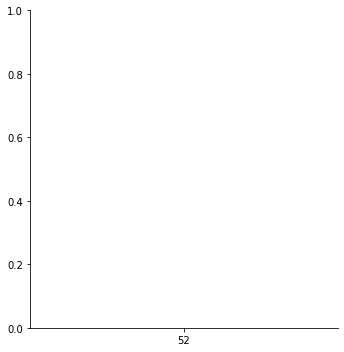

ConversionError: Failed to convert value(s) to axis units: 0               52
1              NaN
2       7920367458
3              NaN
4               22
           ...    
2797            25
2798            27
2799           NaN
2800            24
2801           NaN
Name: x, Length: 2802, dtype: object

In [1378]:
sns.displot(ied.age)

In [1014]:
ied[(ied.wave == '1') & (ied.userid.isin(netusers))].groupby(["ind_treatment", "treatment"]).sleepundernet.value_counts(normalize=True)

ind_treatment  treatment  sleepundernet
0              0          1.0              0.673554
                          0.0              0.326446
               1          1.0              0.709251
                          0.0              0.290749
1              0          1.0              0.711027
                          0.0              0.288973
               1          1.0              0.736842
                          0.0              0.263158
Name: sleepundernet, dtype: float64

In [1053]:
smf.logit('admalaria ~ ind_treatment*treatment', ied[(ied.userid.isin(netusers)) & ied.sleepundernet.notna()]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.535564
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              admalaria   No. Observations:                  875
Model:                          Logit   Df Residuals:                      871
Method:                           MLE   Df Model:                            3
Date:                Tue, 13 Apr 2021   Pseudo R-squ.:                0.006247
Time:                        16:30:06   Log-Likelihood:                -468.62
converged:                       True   LL-Null:                       -471.56
Covariance Type:            nonrobust   LLR p-value:                    0.1170
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3808      0.165     -8.372      0.000      -1.704      -1.058
ind_treatment               0.4617      0.218      2.119      0.034       0.035       0.889
treatment                   0.0301      0.238      0.126      0.899      -0.436       0.496
ind_treatment:treatment    -0.3736      0.326     -1.144      0.253      -1.013       0.266
===========================================================================================
"""

In [1365]:
ied[(ied.userid.isin(netusers)) & ied.sleepundernet.notna()].to_csv('outs/mnm-ied.csv', index=False)

In [1360]:
print(smf.ols('sleepundernet ~ ind_treatment*treatment', ied[(ied.userid.isin(netusers)) & ied.sleepundernet.notna()]).fit().summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}           &  sleepundernet   & \textbf{  R-squared:         } &     0.002   \\
\textbf{Model:}                   &       OLS        & \textbf{  Adj. R-squared:    } &    -0.001   \\
\textbf{Method:}                  &  Least Squares   & \textbf{  F-statistic:       } &    0.7418   \\
\textbf{Date:}                    & Wed, 14 Apr 2021 & \textbf{  Prob (F-statistic):} &    0.527    \\
\textbf{Time:}                    &     20:08:14     & \textbf{  Log-Likelihood:    } &   -593.68   \\
\textbf{No. Observations:}        &         941      & \textbf{  AIC:               } &     1195.   \\
\textbf{Df Residuals:}            &         937      & \textbf{  BIC:               } &     1215.   \\
\textbf{Df Model:}                &           3      & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                  & \textbf{coef} & \textbf{std err} & \textbf{

In [1359]:
expit(0.7243), expit(0.7243 + 0.1761), expit(0.7243 + 0.1674), expit(0.7243 + 0.1761 + 0.1674 - 0.0382)

(0.6735532026572099,
 0.7110316958114002,
 0.7092408682678242,
 0.7368383401414632)

In [1006]:
ied[(ied.wave == '1') & (ied.userid.isin(netusers))].groupby(["ind_treatment", "treatment"]).admalaria.value_counts(normalize=True)

ind_treatment  treatment  admalaria
0              0          0.0          0.799127
                          1.0          0.200873
               1          0.0          0.794258
                          1.0          0.205742
1              0          0.0          0.714876
                          1.0          0.285124
               1          0.0          0.779487
                          1.0          0.220513
Name: admalaria, dtype: float64

In [1028]:
model = Model(ied[(ied.userid.isin(netusers)) & ied.sleepundernet.notna()].reset_index(drop=True))

In [1031]:
results = model.fit('sleepundernet ~ treatment*ind_treatment', family='bernoulli', draws=2_000, tune=4_000)

INFO:bambi:Modeling the probability that sleepundernet==1


INFO:pymc3:Auto-assigning NUTS sampler...


INFO:pymc3:Initializing NUTS using jitter+adapt_diag...


INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)


INFO:pymc3:NUTS: [treatment:ind_treatment, ind_treatment, treatment, Intercept]


INFO:pymc3:Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 26 seconds.


array([<AxesSubplot:title={'center':'treatment'}>,
       <AxesSubplot:title={'center':'ind_treatment'}>,
       <AxesSubplot:title={'center':'treatment:ind_treatment'}>],
      dtype=object)

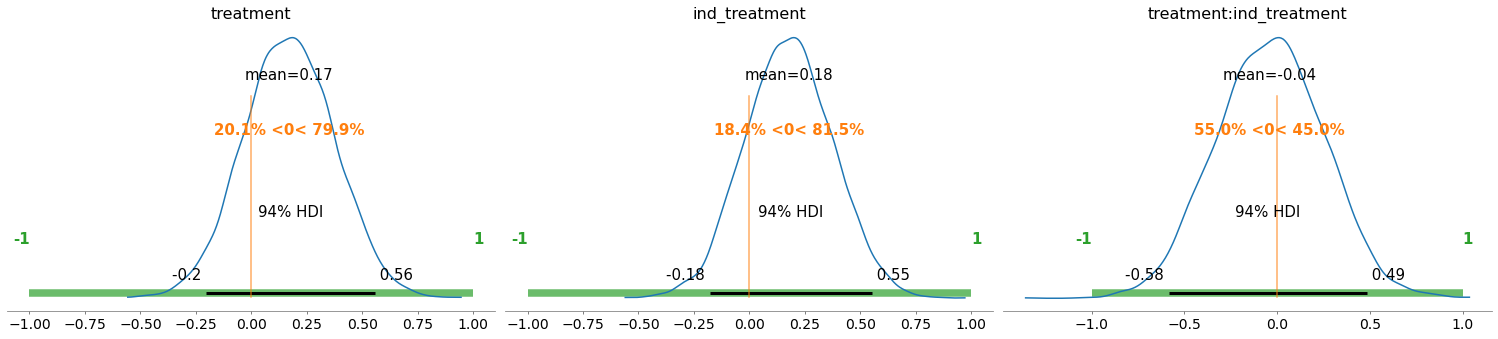

In [1034]:
az.plot_posterior(results, var_names=['treatment','ind_treatment', 'treatment:ind_treatment'], ref_val=0, rope=[-1, 1])

In [1050]:
((results.posterior.treatment.values < 0) & (results.posterior.ind_treatment.values < 0)).mean()

0.0795

In [1051]:
((results.posterior.treatment.values > 0) & (results.posterior.ind_treatment.values > 0)).mean()

0.69375

In [517]:
def remove_spammers(df):
    df = df[(df.answer_time_median.dt.total_seconds()/df.answer_time_min.dt.total_seconds()) >= 1.5]
    return df.reset_index(drop=True)

ddb = remove_spammers(ddb[ddb.dwelling.notna()])

In [856]:
dda = remove_spammers(dda)

In [102]:
import numpy as np

def as_type(series, type_):
    return series.astype(type_)

def binarize(series, pos):
    s = as_type((series == pos), int)
    s[series.isna()] = np.nan
    return s

def binarize_cols(df, cols):
    df = df.copy()
    for col, target in cols:
        df[col] = binarize(df[col], target)
    return df

In [857]:
cols = [
    ('malaria2weeks', 'Yes'), 
    ('fever2weeks', 'Yes'), 
    ('seekhelpfever', 'Yes'),
    ('longsleeves', 'Yes'),
    ('sleepundernet', 'Yes'),
    ('timeseekhelpfever', 'Less than 24 hours')
]

dda = binarize_cols(dda, cols)

In [342]:
dda['stratumid'] = dda.clusterid

In [489]:
ddb[ddb.dwelling.notna() & ddb.seekhelpfever.notna()].seekhelpfever.value_counts()

Yes           1134
No              78
Don’t know       1
Name: seekhelpfever, dtype: int64

In [488]:
ddb[ddb.dwelling.isna() & ddb.seekhelpfever.notna()].seekhelpfever.value_counts()

No            156
Yes            69
Don’t know     16
Name: seekhelpfever, dtype: int64

In [1407]:
cols = [
    ('malaria4months', 'Yes'), 
    ('fever4months', 'Yes'), 
    ('seekhelpfever', 'Yes'),
    ('longsleeves', 'Yes'),
    ('sleepundernet', 'Yes'),
    ('admnm', 'Yes'),
    ('admalaria', 'Yes'),
    ('knowmnm', 'Yes'),
    ('testmalaria', 'Yes'),
]

ddb = binarize_cols(ddb, cols)
ied = binarize_cols(ied, cols)

In [620]:
ddb[(ddb.malaria4months == 1)].fever4months.value_counts(normalize=True)

0.0    0.639175
1.0    0.360825
Name: fever4months, dtype: float64

In [621]:
dda[dda.malaria2weeks == 1].fever2weeks.value_counts(normalize=True)

0.0    0.510264
1.0    0.489736
Name: fever2weeks, dtype: float64

In [629]:
dda[(dda.malaria2weeks == 1) & (dda.fever2weeks == 0)].testmalaria.value_counts()

Yes           206
No            114
Don’t know     21
Name: testmalaria, dtype: int64

In [ ]:
# TODO: build model for malaria incidence that considers
# the selection bias - the fact that only some people 
# get tested, so there is a probability of getting tested,
# and then try to infer effects on malaria incidence.

In [51]:
vpre = get_pair_delta(dda, 'seekhelpfever', ['stratumid', 'treatment'], 'pair_id', pair_lookup, dif('seekhelpfever'))

In [ ]:
import statsmodels.formula.api as smf

pp = vpre[['delta', 'pair_id']].rename(columns={'delta': 'pre_delta'}).merge(v).groupby('pair_id').head(1).reset_index(drop=True)

smf.ols('delta ~ 1 + pre_delta', pp).fit().summary()

In [ ]:
pp

In [ ]:
import seaborn as sns
from toolz import curry
from scipy.stats import rankdata

@curry
def dif(var, df):
    d = df[df.treatment == 1][var].iloc[0] - df[df.treatment == 0][var].iloc[0]
    rd = df[df.treatment == 1]['rank'].iloc[0] - df[df.treatment == 0]['rank'].iloc[0]
    return df.assign(delta = d, count = df['count'].sum(), rank_delta = rd)

def center(a):
    return a - np.mean(a)

def get_pair_delta(df, var, cluster_groups, pair_id, pair_lookup, fn):
    v = df[df[var].notnull()] \
        .groupby(cluster_groups) \
        .agg({var: 'mean', 'userid': 'count'}) \
        .rename(columns={'userid': 'count'}) \
        .pipe(lambda df: df.assign(rank = center(rankdata(df[var])))) \
        .reset_index() \
        .merge(pair_lookup) \
        .groupby(pair_id) \
        .apply(fn)[['delta', 'count', 'rank_delta', pair_id]] \
        .reset_index(drop=True) \
        .sort_values('count')

    return v



# sns.distplot(v['delta'], bins=20)

# np.mean(v.delta)

pair_lookup = pd.read_csv('outs/ma-with-pair-id.csv')[['pair_id', 'disthash']].rename(columns={'disthash': 'stratumid'})
v = get_pair_delta(ddb, 'seekhelpfever', ['stratumid', 'treatment'], 'pair_id', pair_lookup, dif('seekhelpfever'))
# v

sns.distplot(v['delta'], bins=20)
# np.mean(v.delta)



In [522]:
dd = da.rename(columns={'seekhelpfever': 'pre_seekhelpfever'}).merge(d[['seekhelpfever', 'stratumid']], on='stratumid')
dd['delta'] = dd.seekhelpfever - dd.pre_seekhelpfever

In [ ]:
smf.ols('delta ~ treatment', dd.merge(dist_info, left_on='stratumid', right_on='clusterid')).fit().summary()

In [ ]:
d = ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()].groupby(['stratumid', 'treatment']).agg({'seekhelpfever': 'mean', 'userid': 'count'}).reset_index()

smf.ols('seekhelpfever ~ treatment', d).fit().summary()

In [ ]:
sns.histplot(dd, x='delta', hue="treatment", bins=30, kde=True)

<AxesSubplot:xlabel='seekhelpfever', ylabel='Count'>

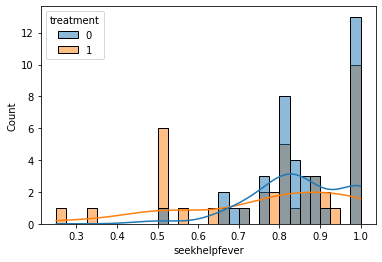

In [892]:
da = dda[(dda.week <= 34) & dda.seekhelpfever.notna()].groupby(['stratumid', 'treatment']).agg({'seekhelpfever': 'mean', 'userid': 'count'}).reset_index()
sns.histplot(da, x='seekhelpfever', hue="treatment", bins=30, kde=True)

In [870]:
smf.ols('seekhelpfever ~ treatment', da).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          seekhelpfever   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     4.573
Date:                Tue, 13 Apr 2021   Prob (F-statistic):             0.0356
Time:                        13:57:15   Log-Likelihood:                 30.077
No. Observations:                  80   AIC:                            -56.15
Df Residuals:                      78   BIC:                            -51.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8599      0.027     32.322      0.000       0.807       0.913
treatment     -0.0805      0.038     -2.138      0.036      -0.155      -0.006
==============================================================================
Omnibus:                        9.802   Durbin-Watson:                   2.355
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.752
Skew:                          -0.827   Prob(JB):                      0.00763
Kurtosis:                       3.439   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:xlabel='seekhelpfever', ylabel='Count'>

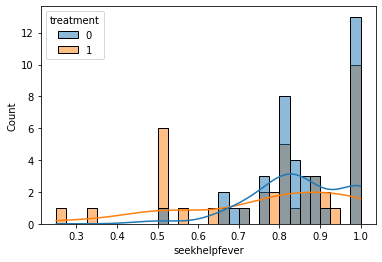

In [896]:
daa = dda[(dda.week >= 38) & dda.seekhelpfever.notna()].groupby(['stratumid', 'treatment']).agg({'seekhelpfever': 'mean', 'userid': 'count'}).reset_index()
sns.histplot(da, x='seekhelpfever', hue="treatment", bins=30, kde=True)

In [ ]:
ddmerge = da.rename(columns = {'seekhelpfever': 'pre_seekhelpfever'}).merge(daa[['stratumid', 'seekhelpfever']], on=['stratumid'])

ddmerge['delta'] = ddmerge.seekhelpfever - ddmerge.pre_seekhelpfever

smf.ols('delta ~ treatment', ddmerge).fit().summary()

In [886]:
smf.ols('seekhelpfever ~ treatment', da).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          seekhelpfever   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.05265
Date:                Tue, 13 Apr 2021   Prob (F-statistic):              0.819
Time:                        13:59:00   Log-Likelihood:                 58.499
No. Observations:                  80   AIC:                            -113.0
Df Residuals:                      78   BIC:                            -108.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8742      0.019     46.875      0.000       0.837       0.911
treatment      0.0061      0.026      0.229      0.819      -0.046       0.059
==============================================================================
Omnibus:                        9.253   Durbin-Watson:                   1.496
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.759
Skew:                          -0.855   Prob(JB):                      0.00760
Kurtosis:                       3.030   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
sns.histplot(d, x='seekhelpfever', hue="treatment", bins=30, kde=True)

In [679]:
permutations = pd.read_csv('outs/cluster-assignments-2.csv').values

In [702]:

@curry
def calc_te(df, t):
    vals = df.assign(treatment = t).groupby('treatment').mean().reset_index().sort_values('treatment').seekhelpfever.values
    return vals[1] - vals[0]


tes = np.array([calc_te(d)(permutations[:, i]) for i in range(1000)])

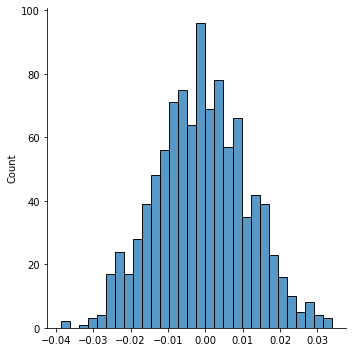

In [703]:
sns.displot(tes, bins=30)

In [704]:
((tes >= .0249).sum() + (tes <= -0.0249).sum()) / tes.shape[0]

0.042

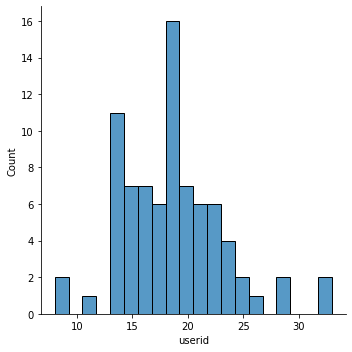

In [714]:
sns.displot(ddb[ddb.seekhelpfever.notna()].groupby('stratumid').count().userid.sort_values(), bins=20)

In [ ]:
@curry
def calc_te(df, ta, t):
    vals = df.drop(columns=['treatment']) \
             .merge(ta.assign(treatment = t), left_on='stratumid', right_on='disthash') \
             .groupby('treatment') \
             .mean() \
             .reset_index() \
             .sort_values('treatment') \
             .seekhelpfever \
             .values

    return vals[1] - vals[0]


tes = np.array([calc_te(ddb[(ddb.wave == '0') & ddb.kutcha & ddb.dwelling.notna()], treatment_assignment)(permutations[:, i]) for i in range(1000)])

In [ ]:
sns.displot(tes, bins=30)

In [ ]:
te_group = calc_te(ddb, treatment_assignment, treatment_assignment.treatment.values)

In [ ]:
te_group

In [ ]:
((tes > te_group).sum() + (tes < -te_group).sum()) / tes.shape[0]

In [644]:
dda.groupby('treatment').seekhelpfever.value_counts(normalize=True)

treatment  seekhelpfever
0          1.0              0.825905
           0.0              0.174095
1          1.0              0.791606
           0.0              0.208394
Name: seekhelpfever, dtype: float64

In [645]:
ddb.groupby('treatment').seekhelpfever.value_counts(normalize=True)

treatment  seekhelpfever
0          1.0              0.938482
           0.0              0.061518
1          1.0              0.958275
           0.0              0.041725
Name: seekhelpfever, dtype: float64

In [ ]:

vv = v.groupby('pair_id').head(1).reset_index(drop=True)

smf.ols('delta ~ 1', vv).fit().summary()

In [308]:
np.mean(vv.delta)

0.02590120769547678

In [ ]:
np.sqrt(np.var(vv.delta)) / np.sqrt(vv.shape[0] - 1)

In [280]:
v = d[d.pucca == False].groupby(['stratumid', 'treatment']).agg({'seekhelpfever': 'mean', 'userid': 'count'}).reset_index()

np.sqrt(v[v.treatment == 1].seekhelpfever.var() + v[v.treatment == 0].seekhelpfever.var())

0.2301406717356983

In [ ]:
import scipy

scipy.stats.t.pdf(13.4, 7, 0, 13.1)

In [306]:

v = d[d.pucca == False] \
    .groupby(['stratumid', 'treatment']) \
    .agg({'seekhelpfever': 'mean', 'userid': 'count'}) \
    .rename(columns={'userid': 'count'}) \
    .pipe(lambda df: df.assign(rank = center(rankdata(df.seekhelpfever)))) \
    .reset_index() \
    .merge(pair_lookup) \
    .groupby('pair_id') \
    .apply(lambda df: dif(df, 'seekhelpfever')) \
    .reset_index(drop=True) \
    .sort_values('count')

# np.mean(v.delta)

# sns.distplot(v.delta, bins=20)

In [ ]:
# build a sense of statistical uncertainty per cluster
# increase repr in that cluster
with pd.option_context("display.max_rows", 160, "display.max_columns", 10):
    display(v)

In [ ]:


d[d.pucca == False] \
    .groupby(['stratumid', 'treatment']) \
    .agg({'seekhelpfever': 'mean', 'userid': 'count'}) \
    .rename(columns={'userid': 'count'}) \
    .reset_index() \
    .merge(pair_lookup) \
    .sort_values('seekhelpfever') \


In [86]:
v = d.groupby(['stratumid', 'treatment']).malaria4months.mean().reset_index().merge(pair_lookup).groupby('pair_id').apply(lambda df: dif(df, 'malaria4months')).delta.values

np.mean(v)

0.002882574759349029

In [923]:
def aggs(df, sums, anys, means):
    r = df.iloc[0]
    # fil = df.wave > 1
    fil = df.week < 36 # 36 = first week of september
    for var in sums:
        r[var] = df[(fil)][var].sum()
    for var in anys:
        r[var] = int(df[(fil)][var].sum() > 0)
    for var in means:
        r[var] = df[(fil)][var].mean()

    r['wave'] = None
    r['waves_answered'] = df[(fil)].shape[0]
    return r


# feature matrix

# user, sum bednet sleeps in follows, if malaria at any point, binary controls (malaria in last 5 years?)

mat = dda \
    .sort_values('week') \
    .groupby('userid') \
    .apply(lambda df: aggs(df, 
                           sums=['fever2weeks', 'seekhelpfever'], 
                           anys=['malaria2weeks'], 
                           means=['sleepundernet', 'longsleeves', 'bednet_share'])) \
    .reset_index(drop=True) \
    .dropna(subset=['sleepundernet'])



In [926]:
mat['seekhelp_if_fever'] = mat.seekhelpfever / mat.fever2weeks

In [921]:
mat.groupby('treatment')['seekhelp_if_fever'].value_counts(normalize=True)

treatment  seekhelp_if_fever
0          1.000000             0.880184
           0.000000             0.110599
           0.500000             0.009217
1          1.000000             0.862944
           0.000000             0.111675
           0.500000             0.010152
           0.333333             0.005076
           0.666667             0.005076
           0.750000             0.005076
Name: seekhelp_if_fever, dtype: float64

In [927]:
mat.groupby('treatment')['seekhelp_if_fever'].value_counts(normalize=True)

treatment  seekhelp_if_fever
0          1.0                  0.855556
           0.0                  0.136111
           0.5                  0.008333
1          1.0                  0.786280
           0.0                  0.200528
           0.5                  0.013193
Name: seekhelp_if_fever, dtype: float64

In [922]:
smf.ols('seekhelp_if_fever ~ treatment', mat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seekhelp_if_fever   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.06341
Date:                Tue, 13 Apr 2021   Prob (F-statistic):              0.801
Time:                        14:11:02   Log-Likelihood:                -112.56
No. Observations:                 414   AIC:                             229.1
Df Residuals:                     412   BIC:                             237.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8848      0.022     40.943      0.000       0.842       0.927
treatment     -0.0079      0.031     -0.252      0.801      -0.069       0.054
==============================================================================
Omnibus:                      195.942   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              611.742
Skew:                          -2.356   Prob(JB):                    1.45e-133
Kurtosis:                       6.641   Cond. No.                         2.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1130]:
smf.ols('seekhelp_if_fever ~ treatment', mat).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      seekhelp_if_fever   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     5.866
Date:                Wed, 14 Apr 2021   Prob (F-statistic):             0.0157
Time:                        08:17:56   Log-Likelihood:                -322.82
No. Observations:                 739   AIC:                             649.6
Df Residuals:                     737   BIC:                             658.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8597      0.020     43.496      0.000       0.821       0.899
treatment     -0.0668      0.028     -2.422      0.016      -0.121      -0.013
==============================================================================
Omnibus:                      199.896   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.981
Skew:                          -1.695   Prob(JB):                     1.13e-83
Kurtosis:                       3.959   Cond. No.                         2.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [913]:
def as_type(series, type_):
    return series.astype(type_)

def quantile(series, q):
    return series > series.quantile(q)

In [64]:
dd['unet'] = dd.under_net.astype(int)

In [145]:
dd['malaria_now_int'] = dd.malaria_now.astype(int)

In [ ]:
dd[dd.wave == 0].malaria_now

In [412]:
ddb.week.value_counts(

1     7306
7     5538
8     5066
9     4568
10    2959
3     2949
6      568
5      560
11     328
4      127
2       99
Name: week, dtype: int64

In [479]:
m = sm.BinomialBayesMixedGLM.from_formula('seekhelpfever ~ treatment', {'a': '0 + C(stratumid)'}, ddb[(ddb.week < 20) & ddb.dwelling.notna() & ddb.seekhelpfever.notna()])
mm = m.fit_vb()

mm.summary()

,Type,Post. Mean,Post. SD,SD,SD (LB),SD (UB)
Intercept,M,2.6096,0.1183,,,
treatment,M,0.5308,0.1901,,,
a,V,-0.3955,0.0790,0.673,0.575,0.789


In [481]:
expit(2.6), expit(2.6 + .53)

(0.9308615796566533, 0.9581133929422073)

In [436]:
! pip install --quiet bambi

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [587]:
ddb[(ddb.malaria4months == 1)].fever4months.value_counts(normalize=True)

0.0    0.641818
1.0    0.358182
Name: fever4months, dtype: float64

In [588]:
ddb[(ddb.malaria4months == 1)].testmalaria.value_counts(normalize=True)

Yes           0.559859
No            0.352113
Don’t know    0.088028
Name: testmalaria, dtype: float64

In [718]:
d = ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()].reset_index(drop=True)
d.loc[d.seekhelpfever == 'No', 'timeseekhelpfever'] = 'Did not seek help'
d = d.dropna(subset=['timeseekhelpfever']).reset_index(drop=True)

In [719]:
from pandas.api.types import CategoricalDtype
 
cat_type = CategoricalDtype(categories=['Less than 24 hours', '24-48 hours', 'More than 2 days', 'Did not seek help'], ordered=True)

d['timeseekhelpfever'] = d.timeseekhelpfever.astype(cat_type)

In [ ]:
import theano.tensor as tt
import pymc3 as pm

stratumid = d.stratumid.astype('category').cat.codes
treatment = d.treatment
P = 80
y = d.timeseekhelpfever.cat.codes
levels = 4

with pm.Model() as ordinal_model:
    intercept = pm.Normal('intercept', mu=0, sigma=2)
    
    stratumid_sigma = pm.HalfCauchy("stratumid_sigma", 2.0)
     
    a_offset = pm.Normal("a_offset", mu=0, sigma=1, shape=P)
    a = pm.Deterministic("a", a_offset*stratumid_sigma)
    b = pm.Normal("b", mu=0, sigma=2)

    eta = intercept + a[stratumid] + b*treatment    
    cutpoints = pm.Normal("cutpoints", mu=np.array([-1,0,1]), sd=1, shape=3, transform=pm.distributions.transforms.ordered)
    yl = pm.OrderedLogistic('obs', cutpoints=cutpoints, eta=eta, observed=y)
    trace = pm.sample(draws=2_000, tune=2_000, return_inferencedata=False)

<AxesSubplot:title={'center':'b'}>

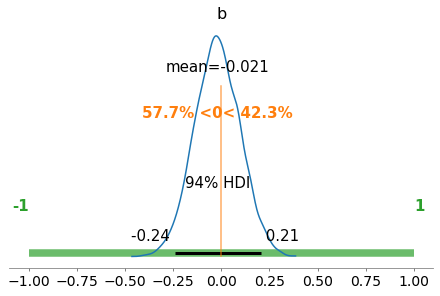

In [779]:
idata = az.from_pymc3(trace, model=ordinal_model)
az.plot_posterior(idata, var_names=['b'], ref_val=0, rope=[-1, 1])

In [788]:
import theano.tensor as tt
import pymc3 as pm

stratumid = d.stratumid.astype('category').cat.codes
treatment = np.repeat(d.treatment.values, 4).reshape(-1, 4)
P = 80
y = d.timeseekhelpfever.cat.codes
levels = 4

with pm.Model() as categorical_model:
    intercept = pm.Normal('intercept', mu=0, sigma=1, shape=levels)
    stratumid_sigma = pm.HalfCauchy("stratumid_sigma", 2.0)
    
    a_offset = pm.Normal("a_offset", mu=0, sigma=1, shape=(P, levels)) 
    a = pm.Deterministic("a", a_offset*stratumid_sigma)
    
    b = pm.Normal("b", mu=0, sigma=1, shape=levels)

    eta = intercept + a[stratumid] + b*treatment    
    p = pm.Deterministic('p', tt.nnet.softmax(eta))
    yl = pm.Categorical('obs', p=p, observed=y)

    trace = pm.sample(draws=4_000, tune=4_000, return_inferencedata=False, target_accept=0.9)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, a_offset, stratumid_sigma, intercept]


INFO:pymc3:Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 365 seconds.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


In [1129]:
trace['b'].shape

(16000, 4)

array([<AxesSubplot:title={'center':'b\n0'}>,
       <AxesSubplot:title={'center':'b\n1'}>,
       <AxesSubplot:title={'center':'b\n2'}>,
       <AxesSubplot:title={'center':'b\n3'}>], dtype=object)

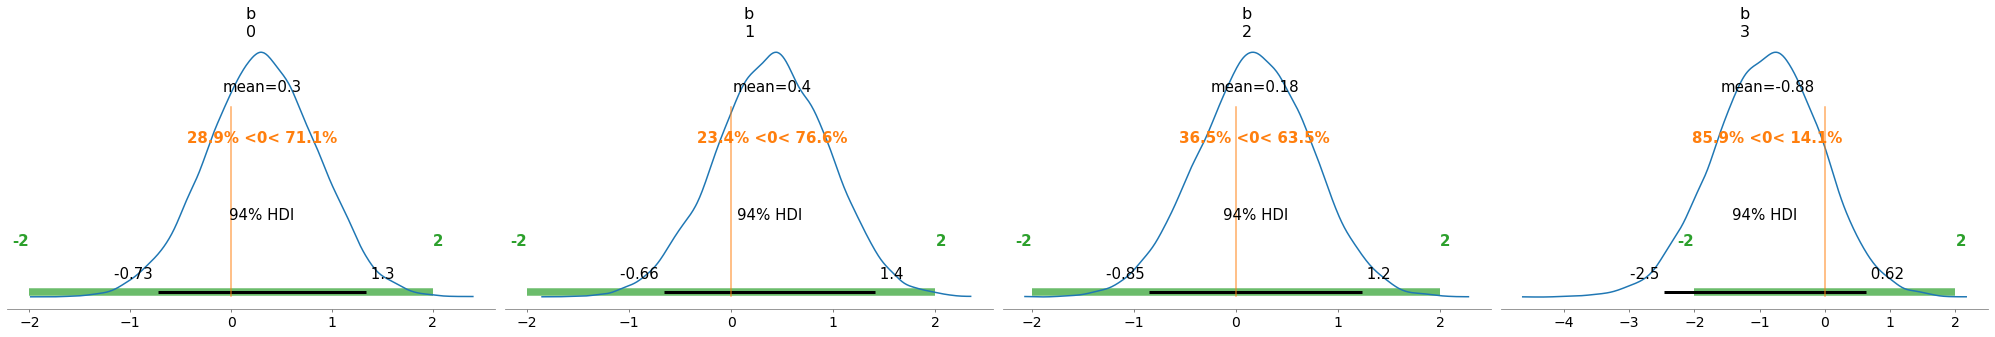

In [789]:
idata = az.from_pymc3(trace, model=categorical_model)
az.plot_posterior(idata, var_names=['b'], ref_val=0, rope=[-2, 2])

In [790]:
((trace['b'][:, 0] > 0) & (trace['b'][:, 3] < 0)).mean()

0.5900625

In [728]:
summary = az.summary(idata)

In [733]:
with moo:
    post_checks = pm.sample_posterior_predictive(trace)

In [734]:
idata = az.from_pymc3(trace, model=moo, posterior_predictive=post_checks)

In [ ]:
post_checks['obs']

In [ ]:
import matplotlib.pyplot as plt

y_pred = post_checks['obs'].mean(0)

jitter = np.random.normal(0, 0.03, len(y))

plt.figure(figsize=(12, 5))
plt.scatter(y + jitter, y_pred, alpha=0.4)
plt.xticks(range(4), d.timeseekhelpfever.unique())
plt.yticks(range(4), d.timeseekhelpfever.unique())

In [867]:
trace.tree_size

array([ 63.,  31.,  31.,  13.,  12.,  63.,  63.,  63.,  63.,  63., 127.,
       127.,  63., 127., 127., 127., 255., 255., 255., 255.])

In [831]:
with m:
    prior_checks = pm.sample_prior_predictive(samples=50)

In [827]:
d.timeseekhelpfever

0         More than 2 days
1       Less than 24 hours
2       Less than 24 hours
3        Did not seek help
4       Less than 24 hours
               ...        
1278    Less than 24 hours
1279      More than 2 days
1280    Less than 24 hours
1281    Less than 24 hours
1282      More than 2 days
Name: timeseekhelpfever, Length: 1283, dtype: category
Categories (4, object): ['24-48 hours' < 'Less than 24 hours' < 'More than 2 days' < 'Did not seek help']

In [16]:
ddb.columns

Index(['userid', 'stratumid', 'wave', 'language', 'week', 'month',
       'survey_duration', 'survey_start_time', 'survey_end_time', 'shortcode',
       'admalaria', 'admnm', 'age', 'buymosquitonet', 'caste', 'castespecify',
       'consent', 'default_tys', 'distancemedicalcenter', 'dwelling',
       'education', 'familymembers', 'fever4months', 'gender',
       'hasairconditioning', 'hasmosquitonet', 'introendline',
       'knowbuymosquitonet', 'knowmnm', 'longsleeves', 'malaria4months',
       'membersbednet', 'membersnotbednet', 'mobilecurrent', 'mobilenumber',
       'mobileoperator', 'notifyme', 'numbermalaria4months',
       'numbermosquitonet', 'occupation', 'paymentprocess', 'paymosquitonet',
       'pregnantwoman', 'religion', 'religionspecify', 'seekhelpfever',
       'sleepundernet', 'sprays', 'talkmalaria', 'testmalaria',
       'timeseekhelpfever', 'timeseekhelpmalaria', 'treatmentseeking',
       'treatmosquitonet', 'typemedicalcenter', 'wait', 'worriedcovid',
       'wor

In [772]:
from bambi import Model

model = Model(ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()].reset_index())

In [758]:
results = model.fit('seekhelpfever ~ treatment + (1 | stratumid)', family='bernoulli', draws=2_000, tune=2_000)

INFO:bambi:Modeling the probability that seekhelpfever==1
INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [1|stratumid_offset, 1|stratumid_sigma, treatment, Intercept]


INFO:pymc3:Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 28 seconds.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<AxesSubplot:title={'center':'treatment'}>

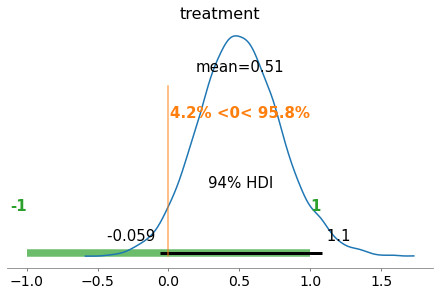

In [768]:
az.plot_posterior(results, var_names=['treatment'], ref_val=0, rope=[-1, 1])

In [ ]:
results = model.fit('seekhelpfever ~ treatment*pucca + (1 | stratumid)', family='bernoulli', draws=2_000, tune=2_000)

array([<AxesSubplot:title={'center':'treatment'}>,
       <AxesSubplot:title={'center':'treatment:pucca'}>], dtype=object)

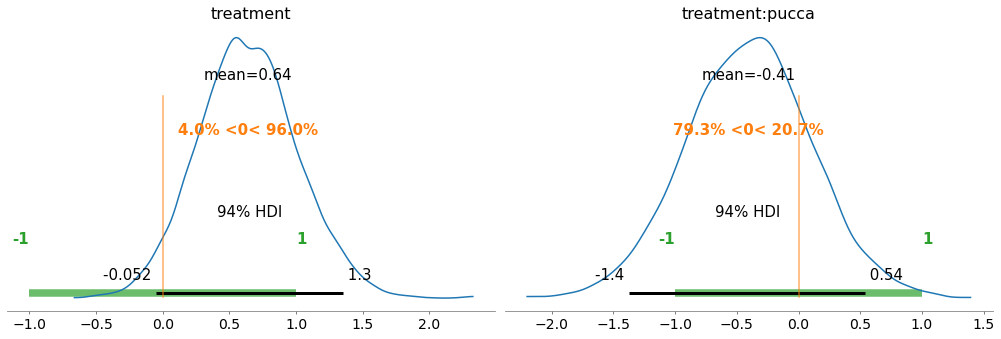

In [774]:
az.plot_posterior(results, var_names=['treatment','treatment:pucca'], ref_val=0, rope=[-1, 1])

In [ ]:
counts = ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()].groupby('stratumid').count().userid.sort_values().reset_index()

In [909]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np


def get_percentages(base, treatment):
    return expit(base), expit(base + treatment), 1 - ((1 - expit(base + treatment))) / (1 - expit(base))

def reg(form, dat, weights_var='waves_answered'):
    try:
        model = smf.glm(form, dat, family=sm.families.Binomial(), var_weights=dat[weights_var])
    except KeyError:
        return smf.logit(form, dat) \
                   .fit(cov_type='cluster', cov_kwds={'groups': dat['stratumid']}) \
                   .summary()

In [208]:
ddb = ddb.merge(dd[['stratumid', 'pre_seekhelpfever']])

In [217]:
reg('seekhelpfever ~ treatment', ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()])

Optimization terminated successfully.
         Current function value: 0.201553
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                 1536
Model:                          Logit   Df Residuals:                     1534
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                0.005712
Time:                        08:42:16   Log-Likelihood:                -309.59
converged:                       True   LL-Null:                       -311.36
Covariance Type:              cluster   LLR p-value:                   0.05930
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7229      0.172     15.860      0.000       2.386       3.059
treatment      0.4426      0.284      1.558      0.119      -0.114       0.999
==============================================================================
"""

In [ ]:
smf.ols('bednet_share ~ treatment', data=mat[mat.hasmosquitonet == 'Yes'], var_weights=mat[mat.hasmosquitonet == 'Yes']['waves_answered']).fit().summary()

In [ ]:
reg('bednet_share ~ treatment*pregnantwoman', mat[mat.hasmosquitonet == 'Yes'])

In [ ]:
reg('sleepundernet ~ treatment*pregnantwoman', mat[mat.hasmosquitonet == 'Yes'])

In [90]:
matb = ddb

matb['seekhelp_if_fever'] = matb['seekhelpfever']
matb['fever2weeks'] = (matb['fever4months'] == 1).astype(int)

In [94]:
f = ddb[ddb.fever4months.notna()]['stratumid'].astype('category').cat.codes.values

In [ ]:
ddb.columns

In [ ]:
ddb.groupby('treatment').admnm.value_counts(normalize=True)

In [ ]:
reg('knowmnm ~ treatment*pucca', ddb[ddb.knowmnm.notna()])

In [111]:
def power(n, p):
    return n**p

In [15]:
from mnm.prep import cast_number

ddb['age'] = ddb.age.map(lambda a: cast_number(0, 100, a))
ddb['young'] = ddb.age < 30

In [11]:
ddb['female'] = (ddb.gender.notna() & (ddb.gender == 'Female') )

In [ ]:
ddb[ddb.admalaria.notna() & ddb.female & ~ddb.young].groupby('treatment').admalaria.value_counts()

In [ ]:
ddb[ddb.admalaria.notna() & ddb.female & ~ddb.young].groupby('treatment').admnm.value_counts()

In [ ]:
reg('admalaria ~ treatment', ddb[ddb.admalaria.notna()])

In [ ]:
reg('admalaria ~ treatment*female*young', ddb[ddb.admalaria.notna() & ddb.gender.notna()])

In [ ]:
from mnm.prep import cast_number

ddb[ddb.admalaria.notna()].age.map(lambda a: cast_number(0, 100, a)).plot.hist()

In [ ]:
ddb[ddb.admalaria.notna()].gender.value_counts(normalize=True)

In [300]:
reg('knowmnm ~ treatment', ddb[ddb.knowmnm.notna()])

Optimization terminated successfully.
         Current function value: 0.500436
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                knowmnm   No. Observations:                 7939
Model:                          Logit   Df Residuals:                     7937
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                 0.01952
Time:                        09:05:55   Log-Likelihood:                -3973.0
converged:                       True   LL-Null:                       -4052.1
Covariance Type:              cluster   LLR p-value:                 2.815e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0556      0.514     -2.054      0.040      -2.063      -0.049
treatment     -0.7227      0.516     -1.401      0.161      -1.734       0.288
==============================================================================
"""

In [301]:
reg('admnm ~ treatment', ddb[ddb.admnm.notna()])

Optimization terminated successfully.
         Current function value: 0.408594
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admnm   No. Observations:                 7797
Model:                          Logit   Df Residuals:                     7795
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 Apr 2021   Pseudo R-squ.:                 0.04016
Time:                        09:06:01   Log-Likelihood:                -3185.8
converged:                       True   LL-Null:                       -3319.1
Covariance Type:              cluster   LLR p-value:                 6.294e-60
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3271      0.640     -2.073      0.038      -2.582      -0.072
treatment     -1.1168      0.644     -1.735      0.083      -2.378       0.145
==============================================================================
"""

In [212]:
get_percentages(-2.1482, -0.2019)

(0.10449954614805741, 0.08705782423611545, -0.019477066523994946)

In [ ]:
reg('admalaria ~ treatment', ddb[ddb.admalaria.notna()])

In [74]:
get_percentages(-1.5669, -0.2552)

(0.17265877040255395, 0.13918208036586574, -0.04046297807855748)

In [ ]:
reg('admalaria ~ treatment*pucca', ddb[ddb.admalaria.notna() & ddb.seekhelpfever.notna()])

In [74]:
get_percentages(-1.706 + 0.4648, -0.0661 - 0.2815)

(0.22422717743519824, 0.16955279551333116, -0.07047731027893822)

In [73]:
get_percentages(-1.706, -0.0661)

(0.15368325421926876, 0.14528136778740763, -0.009927590909370787)

In [154]:
ddb.dwelling.unique()

array([nan, 'Semi-pucca', 'Kutcha (made of mud, tin, straw)',
       'Pucca (have cement/brick wall and floor'], dtype=object)

In [632]:
ddb['kutcha'] = ddb.dwelling == 'Kutcha (made of mud, tin, straw)'
ddb['pucca'] = ddb.dwelling == 'Pucca (have cement/brick wall and floor'

In [ ]:
reg('fever ~ treatment', ddb[ddb.malaria4months.notna() & ddb.fever4months.notna() & ddb.seekhelpfever.notna()])

In [ ]:
reg('testmalaria ~ treatment*pucca', ddb[ddb.dwelling.notna() & ddb.testmalaria.notna()])

In [607]:
ddb.testmalaria.mean()

0.5598006644518272

In [46]:
reg('fever4months ~ treatment*pucca', ddb[ddb.dwelling.notna() & ddb.fever4months.notna()])

Optimization terminated successfully.
         Current function value: 0.462360
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           fever4months   No. Observations:                 4920
Model:                          Logit   Df Residuals:                     4916
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Feb 2021   Pseudo R-squ.:               0.0002249
Time:                        16:25:52   Log-Likelihood:                -2274.8
converged:                       True   LL-Null:                       -2275.3
Covariance Type:              cluster   LLR p-value:                    0.7956
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.5630      0.090    -17.408      0.000      -1.739      -1.387
pucca[T.True]               0.0369      0.116      0.317      0.751      -0.191       0.265
treatment                  -0.0474      0.108     -0.439      0.661      -0.259       0.164
treatment:pucca[T.True]     0.0628      0.164      0.383      0.701      -0.258       0.384
===========================================================================================
"""

In [ ]:
reg('fever4months ~ stratumid', ddb[ddb.dwelling.notna() & ddb.fever4months.notna()])

In [176]:
get_percentages(-1.5630, -0.0474)

(0.17321658792823388, 0.16653308624261706, -0.00808373945102403)

In [180]:
ddb[ddb.seekhelpfever.notna()].groupby('treatment').seekhelpfever.value_counts()

treatment  seekhelpfever
0          0.0              501
1          0.0              464
Name: seekhelpfever, dtype: int64

In [ ]:
smf.logit('seekhelpfever ~ treatment', ddb[ddb.seekhelpfever.notna()]).fit().summary()

In [639]:
reg('seekhelpfever ~ treatment', ddb[ddb.seekhelpfever.notna()])

Optimization terminated successfully.
         Current function value: 0.203132
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                 1483
Model:                          Logit   Df Residuals:                     1481
Method:                           MLE   Df Model:                            1
Date:                Mon, 12 Apr 2021   Pseudo R-squ.:                0.004916
Time:                        14:17:52   Log-Likelihood:                -301.24
converged:                       True   LL-Null:                       -302.73
Covariance Type:              cluster   LLR p-value:                   0.08449
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7249      0.181     15.050      0.000       2.370       3.080
treatment      0.4091      0.291      1.408      0.159      -0.161       0.979
==============================================================================
"""

In [51]:
get_percentages(2.0946, 0.4496)

(0.8903772184388211, 0.9271828978731256, 0.3357484540178699)

In [49]:
get_percentages(1.87, 0.6115)

(0.8664582774667876, 0.9228346818824007, 0.4221632261901672)

In [476]:
smf.ols('seekhelpfever ~ treatment', ddb[(ddb.week < 20) & ddb.dwelling.notna() & ddb.seekhelpfever.notna()]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          seekhelpfever   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.868
Date:                Thu, 18 Mar 2021   Prob (F-statistic):             0.0495
Time:                        16:07:52   Log-Likelihood:                -33.676
No. Observations:                1186   AIC:                             71.35
Df Residuals:                    1184   BIC:                             81.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9195      0.010     91.079      0.000       0.900       0.939
treatment      0.0285      0.014      1.967      0.049     6.8e-05       0.057
==============================================================================
Omnibus:                      842.204   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7324.192
Skew:                          -3.459   Prob(JB):                         0.00
Kurtosis:                      13.018   Cond. No.                         2.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [459]:
reg('seekhelpfever ~ treatment', ddb[(ddb.week < 20) & ddb.dwelling.notna() & ddb.seekhelpfever.notna()])

Optimization terminated successfully.
         Current function value: 0.243136
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                 1186
Model:                          Logit   Df Residuals:                     1184
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                0.006724
Time:                        16:02:33   Log-Likelihood:                -288.36
converged:                       True   LL-Null:                       -290.31
Covariance Type:              cluster   LLR p-value:                   0.04817
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4361      0.168     14.526      0.000       2.107       2.765
treatment      0.4671      0.288      1.622      0.105      -0.097       1.032
==============================================================================
"""

In [460]:
expit(1.5)

0.8175744761936437

In [458]:
expit(2.43)

0.9190865327845347

In [471]:
ddb[ddb.seekhelpfever.notna() & ddb.dwelling.isna()].seekhelpfever.mean()

0.296137339055794

In [467]:
ddb[ddb.seekhelpfever.notna() & ddb.dwelling.notna()].seekhelpfever.mean()

0.9333895446880269

In [473]:
reg('seekhelpfever ~ treatment', ddb[(ddb.week < 20) & ddb.fever4months.notna() & ddb.seekhelpfever.notna()])

Optimization terminated successfully.
         Current function value: 0.457360
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                 1418
Model:                          Logit   Df Residuals:                     1416
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                0.001504
Time:                        16:07:11   Log-Likelihood:                -648.54
converged:                       True   LL-Null:                       -649.51
Covariance Type:              cluster   LLR p-value:                    0.1622
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.4833      0.094     15.726      0.000       1.298       1.668
treatment      0.1976      0.157      1.259      0.208      -0.110       0.505
==============================================================================
"""

In [71]:
reg('seekhelpfever ~ treatment*pucca', ddb[(ddb.week < 10) & ddb.dwelling.notna() & ddb.fever4months.notna() & ddb.seekhelpfever.notna()])

Optimization terminated successfully.
         Current function value: 0.272965
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Tue, 02 Mar 2021   Pseudo R-squ.:                 0.01214
Time:                        10:40:52   Log-Likelihood:                -272.97
converged:                       True   LL-Null:                       -276.32
Covariance Type:              cluster   LLR p-value:                   0.08173
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.0565      0.200     10.287      0.000       1.665       2.448
pucca[T.True]               0.4792      0.352      1.360      0.174      -0.211       1.170
treatment                   0.6318      0.348      1.817      0.069      -0.050       1.313
treatment:pucca[T.True]    -0.3806      0.540     -0.705      0.481      -1.438       0.677
===========================================================================================
"""

In [167]:
reg('seekhelpfever ~ treatment*dwelling', ddb[ddb.dwelling.notna() & ddb.fever4months.notna() & ddb.seekhelpfever.notna()])

Optimization terminated successfully.
         Current function value: 0.355515
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          seekhelpfever   No. Observations:                  677
Model:                          Logit   Df Residuals:                      671
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                 0.01323
Time:                        10:41:37   Log-Likelihood:                -240.68
converged:                       True   LL-Null:                       -243.91
Covariance Type:              cluster   LLR p-value:                    0.2647
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         1.4843      0.262      5.672      0.000       0.971       1.997
dwelling[T.Pucca (have cement/brick wall and floor]               0.6776      0.396      1.713      0.087      -0.098       1.453
dwelling[T.Semi-pucca]                                            0.3075      0.415      0.741      0.459      -0.506       1.121
treatment                                                         0.6492      0.525      1.236      0.217      -0.380       1.679
treatment:dwelling[T.Pucca (have cement/brick wall and floor]    -0.4561      0.642     -0.710      0.478      -1.715       0.802
treatment:dwelling[T.Semi-pucca]                                 -0.2029      0.727     -0.279      0.780      -1.629       1.223
=================================================================================================================================
"""

In [153]:
get_percentages(1.48, 0.6492)

(0.8145725807070178, 0.8937090377022275, 0.4267786139555295)

In [136]:
get_percentages(1.573, 0.2663)

(0.8282108615242946, 0.8628658986241335, 0.20173008263115488)

In [119]:
m = pd.concat([mat, matb])
reg('seekhelp_if_fever ~ treatment', m[m.seekhelp_if_fever.notna()], 'fever2weeks')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      seekhelp_if_fever   No. Observations:                 1598
Model:                            GLM   Df Residuals:                     1596
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -804.38
Date:                Sun, 07 Feb 2021   Deviance:                       1516.7
Time:                        18:02:54   Pearson chi2:                 1.76e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6309      0.087     18.687      0.000       1.460       1.802
treatment      0.1977      0.127      1.561      0.118      -0.050       0.446
==============================================================================
"""

In [137]:
get_percentages(1.6309, 0.1977)

(0.8362928924541598, 0.8615948625093831, 0.15455633194263352)

In [137]:
reg('seekhelp_if_fever ~ treatment', mat[mat.seekhelp_if_fever.notna()], 'fever2weeks')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:      seekhelp_if_fever   No. Observations:                 1005
Model:                            GLM   Df Residuals:                     1003
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -556.27
Date:                Sun, 07 Feb 2021   Deviance:                       1020.5
Time:                        18:20:19   Pearson chi2:                 1.17e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6468      0.107     15.452      0.000       1.438       1.856
treatment      0.1449      0.151      0.960      0.337      -0.151       0.441
==============================================================================
"""

In [125]:
reg('fever4months ~ treatment', matb)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           fever4months   No. Observations:                 4951
Model:                            GLM   Df Residuals:                     4949
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1814.3
Date:                Sun, 07 Feb 2021   Deviance:                       3628.7
Time:                        18:12:45   Pearson chi2:                 4.95e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9782      0.061    -32.593      0.000      -2.097      -1.859
treatment     -0.0339      0.088     -0.387      0.699      -0.206       0.138
==============================================================================
"""

In [126]:
reg('fever2weeks ~ treatment', mat)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            fever2weeks   No. Observations:                 6496
Model:                            GLM   Df Residuals:                     6494
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4306.4
Date:                Sun, 07 Feb 2021   Deviance:                       5633.2
Time:                        18:12:47   Pearson chi2:                 8.75e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.7039      0.041    -66.740      0.000      -2.783      -2.625
treatment      0.1145      0.056      2.041      0.041       0.005       0.224
==============================================================================
"""

In [115]:
reg('malaria4months ~ treatment', matb)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         malaria4months   No. Observations:                 5001
Model:                            GLM   Df Residuals:                     4999
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -965.49
Date:                Sun, 07 Feb 2021   Deviance:                       1931.0
Time:                        17:59:59   Pearson chi2:                 5.00e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0466      0.095    -32.197      0.000      -3.232      -2.861
treatment      0.1270      0.132      0.962      0.336      -0.132       0.386
==============================================================================
"""

In [116]:
expit(-3.0466), expit(0.1270)

(0.045364488367139494, 0.5317073940719488)

In [130]:
reg('malaria2weeks ~ treatment', mat, 'foo')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          malaria2weeks   No. Observations:                 6496
Model:                            GLM   Df Residuals:                     6494
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1526.8
Date:                Sun, 07 Feb 2021   Deviance:                       3053.5
Time:                        18:15:45   Pearson chi2:                 6.50e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6843      0.072    -37.365      0.000      -2.825      -2.543
treatment     -0.0320      0.102     -0.313      0.754      -0.232       0.168
==============================================================================
"""

In [132]:
expit(-2.6843), expit(-2.6943 - 0.0320)

(0.06390615823520344, 0.061439175217968434)

In [ ]:
dd[dd.wave == 0].groupby('treatment').long_sleeves.mean()

In [ ]:
reg('as_type(under_net, int) ~ treatment:as_type(wave, str) + avg_under_net', dd[(dd.userid.isin(mat[mat.net_ownership].userid)) & (dd.wave > 0)])

In [ ]:
reg('as_type(under_net, int) ~ treatment:as_type(month, str) + avg_under_net', dd[(dd.userid.isin(mat[mat.net_ownership].userid)) & (dd.wave > 0)])

In [ ]:
reg('as_type(long_sleeves, int) ~ treatment:as_type(month, str) + avg_long_sleeves', dd)

In [ ]:
reg('as_type(long_sleeves, int) ~ treatment', dd[dd.wave == 0])

In [ ]:
reg('as_type(under_net, int) ~ treatment', dd[dd.wave == 0])

In [ ]:
reg('as_type(malaria_now, int) ~ treatment', dd[dd.wave == 0])

In [ ]:
reg('malaria_now ~ treatment', mat)

In [ ]:
mat['num_under_net'].max()

In [ ]:
reg('num_under_net ~ treatment', mat[(mat['owns_net'] == 'Yes')]) 

In [ ]:
reg('long_sleeves ~ treatment + avg_long_sleeves', mat) 

In [ ]:
reg('under_net ~ treatment', mat[mat['owns_net'] == 'Yes'])

In [ ]:
reg('under_net ~ treatment*pregnant_in_house', mat[mat['owns_net'] == 'Yes'])

In [ ]:
reg('under_net ~ treatment*quantile(avg_malaria_now, 0.5)', mat[mat['owns_net'] == 'Yes'])

In [ ]:
reg('under_net ~ treatment*kutcha*quantile(avg_malaria_now, 0.5)', mat[mat['owns_net'] == 'Yes'])

In [1413]:
expit(0.5991)

0.6454503734274153

In [1412]:
expit(0.5991 + 0.023)

0.6506960099929763

In [1416]:
expit(0.5991 - 0.2387)

0.5891372593292695

In [1414]:
expit(0.5991 + 0.023 + 0.1558 - 0.2387)

0.6316262977304613

In [ ]:
reg('under_net ~ treatment', mat[mat['owns_net'] == 'Yes'])

In [1379]:
expit(0.529)

0.6292498476593299

In [1388]:
expit(0.48)

0.617747874769249

In [1389]:
expit(0.58)

0.6410674063348171

In [1405]:
expit(0.349), expit(0.611)

(0.5863750605361624, 0.648168881838421)

In [1404]:
expit(0.58 - 0.09), expit(0.58 + 0.289)

(0.6201064323430902, 0.7045375762042413)

0.7045375762042413

In [ ]:
reg('under_net ~ treatment*lower_caste*quantile(avg_malaria_now, 0.5) + avg_under_net', mat[mat['owns_net'] == 'Yes'])

In [ ]:
reg('long_sleeves ~ treatment*lower_caste*quantile(avg_malaria_now, 0.5) + avg_long_sleeves', mat)

In [415]:
mat.malaria_now.sum()

0

In [410]:
mat.groupby('clusterid').malaria_now.sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [383]:
mat.groupby('treatment').malaria_now.value_counts(normalize=True)

treatment  malaria_now
0          0              0.917864
           1              0.082136
1          0              0.910769
           1              0.089231
Name: malaria_now, dtype: float64

In [ ]:
df.clusterid

In [ ]:
df.wave == 0

In [768]:
dist_info['high_malaria_district'] = dist_info.avg_malaria_now > 0.02

In [495]:
dd[dd.wave == 0].groupby('clusterid').apply(lambda df: df.malaria_now.sum()).values

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 2, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
dist_info

In [ ]:
mm

In [543]:
smf.logit('malaria_now ~ treatment*avg_malaria_now*cost_per_message', mm).fit().summary()

Optimization terminated successfully.
         Current function value: 0.287730
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            malaria_now   No. Observations:                 1949
Model:                          Logit   Df Residuals:                     1941
Method:                           MLE   Df Model:                            7
Date:                Wed, 02 Dec 2020   Pseudo R-squ.:                 0.01610
Time:                        16:37:02   Log-Likelihood:                -560.79
converged:                       True   LL-Null:                       -569.96
Covariance Type:            nonrobust   LLR p-value:                   0.01047
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                     -1.9847      0.738     -2.689      0.007      -3.431      -0.538
treatment                                      0.4164      1.093      0.381      0.703      -1.725       2.558
avg_malaria_now                                0.0445     38.359      0.001      0.999     -75.138      75.227
treatment:avg_malaria_now                    -11.6342     51.275     -0.227      0.821    -112.130      88.862
cost_per_message                              -0.0403      0.034     -1.195      0.232      -0.106       0.026
treatment:cost_per_message                    -0.0314      0.054     -0.581      0.561      -0.138       0.075
avg_malaria_now:cost_per_message               0.9171      1.603      0.572      0.567      -2.225       4.059
treatment:avg_malaria_now:cost_per_message     0.9822      2.285      0.430      0.667      -3.496       5.461
==============================================================================================================
"""

In [438]:
df[(df.variable == 'net_lastnight') & (df.wave == 0)].groupby('treatment').translated_response.value_counts(normalize=True)

treatment  translated_response
0          Yes                    0.569815
           No                     0.430185
1          Yes                    0.562628
           No                     0.437372
Name: translated_response, dtype: float64

In [440]:
df.timestamp

1197     2020-07-23 08:06:51.476000+00:00
1190     2020-07-23 08:07:00.147000+00:00
1165     2020-07-23 08:07:55.339000+00:00
1181     2020-07-23 08:08:15.220000+00:00
1196     2020-07-23 08:08:21.454000+00:00
                       ...               
119064   2020-12-02 08:32:00.924000+00:00
95367    2020-12-02 08:57:51.108000+00:00
95615    2020-12-02 08:58:27.031000+00:00
95616    2020-12-02 08:59:03.112000+00:00
95623    2020-12-02 08:59:11.999000+00:00
Name: timestamp, Length: 83171, dtype: datetime64[ns, psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)]

In [439]:
df[(df.variable == 'net_lastnight') & (df.wave > 5)].groupby('treatment').translated_response.value_counts(normalize=True)

treatment  translated_response
0          Yes                    0.519062
           No                     0.480938
1          Yes                    0.572917
           No                     0.427083
Name: translated_response, dtype: float64

In [198]:
df[(df.variable == 'net_lastnight') & (df.wave > 0)] \
    .groupby('userid') \
    .apply(lambda df: df.assign(summed = (df.translated_response == 'Yes').sum())) \
    .groupby('treatment') \
    .summed.mean()

treatment
0.0    3.153181
1.0    3.222683
Name: summed, dtype: float64

In [ ]:
df[(df.variable == 'long_sleeves') & (df.wave == 0)].groupby('treatment').translated_response.value_counts(normalize=True)

In [408]:
df[(df.variable == 'long_sleeves') & (df.wave > 5)].groupby('treatment').translated_response.value_counts(normalize=True)

treatment  translated_response
0          Yes                    0.675000
           No                     0.325000
1          Yes                    0.653153
           No                     0.346847
Name: translated_response, dtype: float64

In [1070]:
bl = dda[dda.wave == 0]
bl = binarize_cols(bl, [('malaria5year', 'Yes')])

In [1073]:
bl.malaria5year

1859.0

164.0

In [1090]:
def _convert_cat(col):
    try:
        return col.cat.codes
    except AttributeError:
        return None

def convert_cats(df):
    cols = [(col, _convert_cat(df[col])) for col in df.columns]
    cols =  [(n, c) for n, c in cols if c is not None]
    names, cols = zip(*cols)
    return cols

def ordinalize(df, col, vals):
    t = CategoricalDtype(categories=vals, ordered=True)
    df[col] = df[col].astype(t)
    return df

In [1101]:
bl = ordinalize(bl, 'distancemedicalcenter', ['Less than 15 minutes', 'Between 15 and 30 minutes', 'Between 30 and 60 minutes', 'More than 60 minutes'])
bl = ordinalize(bl, 'education', ['Never attended school', 'Primary', 'Secondary', 'University degree or higher'])
bl = ordinalize(bl, 'home', ['Kutcha (made of mud, tin, straw)', 'Semi-pucca', 'Pucca (have cement/brick wall and floor'])

In [1265]:
bl['age'] = bl.age.map(lambda x: cast_number(15, 90, x)).astype(float)
bl['familymembers'] = bl.familymembers.map(lambda x: cast_number(0, 30, x)).astype(float)

In [1253]:
bl['unemployed'] = bl.occupation == 'Unemployed'
bl['self_employed'] = bl.occupation == 'Self-employed'
bl['student'] = bl.occupation == 'Student'
bl['employed_fulltime'] = bl.occupation == 'Employed-full time'

In [1258]:
bl['general_caste'] = bl.caste == 'General'
bl['lower_caste'] = bl.caste.isin(['OBC', 'SC/Dalit', 'ST'])

In [1318]:
bl['female'] = bl.gender == 'Female'

In [1337]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from dtreeviz.trees import *

model = DecisionTreeClassifier(max_depth=2)

df = bl.dropna(subset=['malaria2weeks', 'distancemedicalcenter', 'education', 'home', 'familymembers', 'age']).reset_index(drop=True)
df = df[df.age >= 18].reset_index(drop=True)
y = df.malaria2weeks
# df['kutcha'] = df.home == 'Kutcha (made of mud, tin, straw)'
# df['pucca'] = df.home == 'Pucca (have cement/brick wall and floor'
picked = ['age', 'female', 'unemployed', 'self_employed', 'student', 'employed_fulltime', 'general_caste', 'lower_caste']
X = df[picked]

X = pd.concat([X, *convert_cats(df[['distancemedicalcenter', 'education', 'home']])], axis=1)
X.columns = picked + ['distancemedicalcenter', 'education', 'dwelling']

model.fit(X, y)

viz = dtreeviz(model, 
               X, 
               y,
               target_name='malaria2weeks',
               feature_names=X.columns, 
               # fancy=False
              )  


In [ ]:
viz

In [1333]:
viz.save('outs/images/malaria5year.svg')

In [1334]:
X['malaria2weeks'] = df.malaria5year
X.corr()['malaria2weeks'].round(3).sort_values()

dwelling                -0.068
general_caste           -0.048
self_employed           -0.032
age                     -0.023
female                  -0.012
employed_fulltime       -0.009
student                  0.009
familymembers            0.017
unemployed               0.021
education                0.038
distancemedicalcenter    0.049
lower_caste              0.056
malaria2weeks            1.000
Name: malaria2weeks, dtype: float64

In [1385]:
ddb['kutcha'] = ddb.dwelling == 'Kutcha (made of mud, tin, straw)'
ddb['pucca'] = ddb.dwelling == 'Pucca (have cement/brick wall and floor'

In [ ]:
with sns.color_palette('Set2'):
    # _, ax = plt.subplots(figsize=(16, 5))
    sns.displot(ddb[ddb.dwelling.notna()].groupby('stratumid').kutcha.mean(), alpha = 0.5, kde=True)

In [1220]:
X['y'] = y

In [ ]:
X.corr()

In [ ]:
# LOOK AT CHANGE IN INDIVIDUAL BEHAVIOR, DIF IN DIF!
# Too weak, 82 users :(

early_fever_users = dda[(dda.week < 36) & dda.seekhelpfever.notna()].userid.unique()
fu = dda[(dda.userid.isin(early_fever_users)) & (dda.week > 38) & dda.seekhelpfever.notna()].groupby('userid').apply(lambda df: df.sort_values('week').iloc[-1]).reset_index(drop=True)

base = dda[(dda.userid.isin(fu.userid)) & (dda.week < 36) & dda.seekhelpfever.notna()].groupby('userid').apply(lambda df: df.sort_values('week').iloc[0]).reset_index(drop=True).rename(columns = {'seekhelpfever': 'pre_seekhelpfever'})

combo = base[['userid', 'pre_seekhelpfever', 'treatment']].merge(fu[['userid', 'seekhelpfever']])
combo['dif'] = combo.seekhelpfever - combo.pre_seekhelpfever

smf.ols('dif ~ treatment', combo).fit().summary()